# <center> Lecture12 : Logistic Regression </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## 回顾：贝叶斯视角下的回归模型  

在贝叶斯统计框架下，回归模型的构建与检验方法与传统频率学派有所不同。  
* 在贝叶斯回归中，模型的参数被视为随机变量，通过数据来更新其概率分布。  
* 贝叶斯方法通过对参数的**后验分布**进行推断，从而评估模型的适应性与显著性。  
* 这种方法使得我们不仅能得到参数的点估计，还能获得关于这些参数的不确定性的信息。  

在之前的课件中，我们以自我优势匹配范式为例，建立了一个简单的线性回归模型：  

$$  
RT_{sec} \sim \mathcal{N}(\beta_0 + \beta_1 \cdot Label, \sigma^2)  
$$  

在这个模型中，反应时间（$RT_{sec}$）是一个连续的因变量。  




🤔 然而，在许多心理学研究中，另一个常见的因变量是反应是否正确，这通常是一个二分变量（正确/错误）。  

当因变量是二分变量时，传统的线性回归模型就不再适用。 在这种情况下，大家可能会想到使用**逻辑回归**（Logistic Regression）模型来探讨因变量为二分变量的情况。  

那么，在贝叶斯框架下，我们应该如何构建和处理逻辑回归（Logistic Regression）模型呢？  


![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/720/h/960)  

<div style="padding-bottom: 30px;"></div>

### 以随机点运动任务为例：贝叶斯逻辑回归  

接下来，我们以之前介绍过的**随机点运动任务**（Random Motion Dot Task）为例，来理解贝叶斯逻辑回归模型的应用。  

* 在这个实验中，参与者观察屏幕上随机运动的点，这些点的运动方向具有一定的一致性（即大部分点朝某一方向移动）。  
* 参与者的任务是判断这些点的主要移动方向（例如，向左还是向右）。  

实验的设计可以控制点的运动一致性（如10%或40%），从而影响参与者作出正确决策的难度。  

<center>  
    <table>  
            <tr>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyi477j.gif?imageView2/0/w/400/h/400" alt=""></td>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyt1yq4.gif?imageView2/0/w/400/h/400" alt=""></td>  
            </tr>  
            <tr>  
                <td>一致性10%</td>  
                <td>一致性40%</td>  
            </tr>  
    </table>  
</center>  

**和之前的内容不同，本次课我们将研究点的运动一致性与判断是否正确之间的关系**：  

1. **自变量：** 点的运动一致性（10% 一致性 与 40% 一致性）；  
2. **因变量：** 判断是否正确（即被试是否准确判断了点的主要运动方向，1代表反应正确，0代表反应错误）。  

<div style="padding-bottom: 30px;"></div>

以Evans et al.（2020, Exp. 1） 的数据为例进行探索。  

> Evans, N. J., Hawkins, G. E., & Brown, S. D. (2020). The role of passing time in decision-making. Journal of Experimental Psychology: Learning, Memory, and Cognition, 46(2), 316–326. https://doi.org/10.1037/xlm0000725  


In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 使用 pandas 导入示例数据
try:
  df = pd.read_csv("/home/mw/input/bayes3797/evans2020JExpPsycholLearn_exp1_full_data.csv") 
except:
  df = pd.read_csv('data/evans2020JExpPsycholLearn_exp1_full_data.csv')

# 筛选编号为 31727 的数据，并且筛选出两个不同的 percentCoherence
df_clean = df[(df['subject'] == 31727) & (df['percentCoherence'].isin([10, 40]))]
df_clean  = df_clean[["subject", "percentCoherence", "correct"]]

df_clean

,subject,percentCoherence,correct
0,31727,10,1
1,31727,40,0
3,31727,40,1
6,31727,10,1
7,31727,10,1
...,...,...,...
1095,31727,10,1
1097,31727,10,1
1098,31727,10,1
1099,31727,40,1


In [4]:
df_clean.groupby("percentCoherence").correct.mean()

percentCoherence
10    0.686047
40    0.926316
Name: correct, dtype: float64

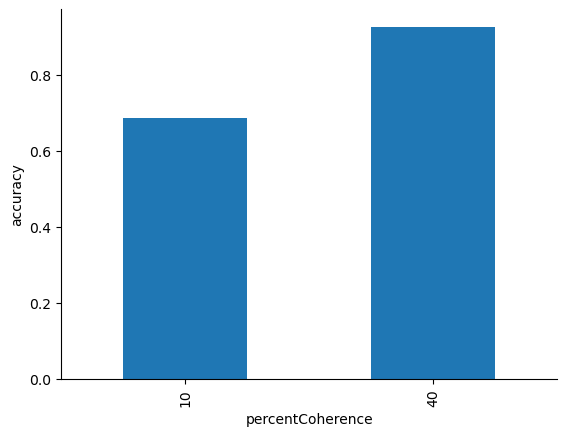

In [5]:
# 因变量分布
ax = df_clean.groupby("percentCoherence").correct.mean().plot.bar()

ax.set_ylabel("accuracy")
sns.despine()
plt.show()

通过散点图，我们可以直观地观察到数据中不同变量的分布情况：  



![Image Name](https://cdn.kesci.com/upload/so1p92nbg9.jpeg?imageView2/0/w/960/h/960)  


#### 二分数据、伯努利分布与线性回归  

在示例数据中中，  
* 因变量“correct”是一个二分类变量，表示被试是否获得正确反应。  
* 我们考虑的自变量“percentCoherence”可以是连续变量，表示被试的刺激强度 (percentCoherence 或 motion strength)。  
* 我们感觉兴趣的是“correct”与“percentCoherence”之间的关系。   

**问题：我们是否能用线性回归来对分析这些数据？**  

<center> <img src='https://cdn.kesci.com/upload/skeayxhg1s.png?imageView2/0/w/700'> </center>  

> Shooshtari, S. V., Sadrabadi, J. E., Azizi, Z., & Ebrahimpour, R. (2019). Confidence representation of perceptual decision by EEG and eye data in a random dot motion task. Neuroscience, 406, 510–527. https://doi.org/10.1016/j.neuroscience.2019.03.031  

仅考虑两种刺激强度(percentCoherence)下的数据，即 $x = 0.1$ 和 $x = 0.4$。  

如何使用线性回归来对这种数据进行拟合？ $y_i = \beta_0 + \beta_1 * x_i$ or $Y_i \sim N(\mu, \sigma), \mu = \beta_0 + \beta_1 * x_i$  

通常线性回归模型中因变量需要是连续的、从正无穷到负无穷，但上述数据中，不管是每个试次的反应，还是伯努利分布的参数$\pi$都不满足线性回归的预设。  

![Image Name](https://cdn.kesci.com/upload/snyz4sbvfv.png?imageView2/0/w/640/h/640)

**Step 1**: 如果不能直接对二分变量进行回归分析，是否可以考虑对产生二分变量的模型参数进行回归分析？  

正确反应的概率可以看作是一个伯努利分布，即 $Y_i | \pi_i \sim \text{Bern}(\pi_i)$，其中 $\pi_i$ 是在刺激强度 $x_i$ 下被试获得正确反应的概率。  

* 曲线上的每一个点，都服从伯努利分布 $Y_i | \pi_i \sim \text{Bern}(\pi_i)$  

此时，$\pi$ 在 0-1之间，因此仍然不满足线性回归的要求，但似乎可以用了.  

思考：传统上我们对正确率进行*t*-test是不是就相当于直接对 $\pi$ 进行回归分析？这种做法有什么问题？

## Probability & Odds  

**Step 2**: 进一步对$\pi$进行转换，引入概念：**发生比(odds)**。

**发生比(odds)**  

与概率不同，发生比(odds)描述的是 **事件发生概率** 与 **事件不发生概率**之比 ，而概率则描述了事件发生的绝对可能性。  

我们用“明天是否会下雨”的例子来进行说明。  

在这个例子中，$\pi$为因变量$Y$发生的概率  

$$  
\begin{equation}  
\text{odds} = \frac{\pi}{1-\pi} \;\;,\;\;\;  
\pi = \frac{\text{odds}}{1 + \text{odds}}  
\end{equation}  
$$  

* 比如，明天下雨发生的概率是$\pi = 2/3$，则明天不下雨的概率为$1 - \pi = 1/3$  

    * 在这个例子中，将 $\pi$ 带入公式得到发生比 odds 为2，明天下雨的可能性是不下雨可能性的两倍  
    
    * $\pi$的值在$(0,1)$之间，odds的范围则可以是$(0,+\infty)$  
$$  
\text{odds of rain } = \frac{2/3}{1-2/3} = 2  
$$  



事件的发生概率$\pi \in [0,1]$，事件对应的发生比为$\;\;\;\pi / (1-\pi) \in [0, \infty)$  

> 将发生比与1进行比较来衡量事件发生的不确定性：  

1. 当事件发生的概率$\pi < 0.5$时，事件的发生比小于1  

2. 当事件发生的概率$\pi = 0.5$时，事件的发生比为等于1  

3. 当事件发生的概率$\pi > 0.5$时，事件的发生比为大于1  

问题：Odds仍然不是在正负无穷上均有取值，怎么办？

**Step 3**: 进一步对Odds进行转换，让其在正负无穷上均有取值：$log(odds)$  

$\log(\text{odds}_i) = \beta_0 + \beta_1 X_{i1}$  

这种情况之下，我们可以使用线性回归模型来完成数据分析了，只是对因变量进行了几次转换，使之满足了线性回归模型的假设条件。  

总结起来：  

$$y_i \sim Bern (\pi) $$  

$$odds = \frac {\pi}{1 - \pi}$$  

$$\log(\text{odds}) = \beta_0 + \beta_1 X$$  

* 在广义线性模型中，我们需要**连接函数(link function)**$g(\cdot)$，使得参数g($\pi_i$)可以被表示为自变量$X_{i1}$的线性组合  

![Image Name](https://cdn.kesci.com/upload/snyjmb20r4.png?imageView2/0/w/960/h/960)  



### 公式中各参数的意义  

$$  
\log(\text{odds}) = \log\left(\frac{\pi}{1-\pi}\right) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p  
$$  

也可以写成：$$\text{odds} = e^{\beta_0 + \beta_1 X_{1} +\cdots + \beta_p X_p}$$  

$\beta_0$ 是截距项，也称为 常数项，它表示当所有自变量（$X_1, X_2, \dots, X_p$）都为零时，log（odds） 的基线值。换句话说，$\beta_0$ 表示模型在无任何预测变量影响时的log（odds）。  

$\beta_1, \beta_2, \dots, \beta_p$ 是回归系数，分别表示每个预测变量（$X_1, X_2, \dots, X_p$）对 log（odds）的影响。每个 $\beta_i$ 表示对应自变量 $X_i$ 增加一个单位时，log（odds）变化的大小。  

> Gelman, A., &#38; Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models. Cambridge: Cambridge University Press. 

* $\beta_0$  

    * 当$(X_1,X_2,\ldots,X_p) = 0$时，$\text{odds} = e^{\beta_0}$，即$e^{\beta_0}$表示当所有自变量为0时，事件的发生比  

* $\beta_1$  

    * $\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x)\;\;\;$ → $\;\;\; e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}$  

    * 当其他自变量保持不变时，$X_1$每增加一个单位（从$x$ → $x+1$），$e^{\beta_1}$表示事件发生比的倍数变化  

* 计算  

    $\log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i1}\;\;\;$ →  $\;\;\;\frac{\pi_i}{1-\pi_i} = e^{\beta_0 + \beta_1 X_{i1}}\;\;\;$ →  $\;\;\;\pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}}$  

## 广义线性模型(Generalized Linear Model, GLM)  
* 对线性回归模型的推广  
* 在因变量不满足线性模型的预设条件时，仍然使用线性模型的思路。  
* 核心在于通过连接函数对因变量进行变换，使其满足线性模型的条件。  
* 对二分变量的广义线性模型称为逻辑回归，还有大量适用于其他数据的广义线性模型，本质上是一致的。  
* 回归系数的解释是难点，需要领域特殊的知识。

### 补充知识：更多可用的分布  

|分布类型|描述概率|描述发生比|适用情况说明|  
|---|---|---|---|  
|二项分布|是|否|描述n次独立伯努利试验中成功次数的概率分布。|  
|贝塔分布|是|是|描述伯努利试验中成功概率的先验分布，也可以用来描述发生比。|  
|对数正态分布|否|是|描述正态分布变量取对数后的分布，常用于描述正比于发生比的数据。|  
|泊松分布|是|否|描述在固定时间或空间内发生某事件的次数的概率分布。|  
|伽马分布|否|是|描述等待时间的分布，常用于作为泊松分布中事件发生率的先验分布，因此可以用来描述发生比。|  
|负二项分布|是|否|描述在获得r次成功之前经历n次试验的概率分布，适用于成功概率不固定的情况。|  
|多项分布|是|否|描述多项式试验中各种结果次数的概率分布。|  
|Dirichlet分布|是|是|描述多项分布中各种结果概率的先验分布，也可以用来描述发生比。|

## 贝叶斯广义线性模型的定义  

现在，我们已经了解了逻辑回归模型的基本结构，我们可以开始定义模型了。  
* 我们需要确定变量类型和分布。  
* 需要根据连接函数（link function）来设置转化参数。  
* 并且为转化后的参数设置先验分布。  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}} \\  
\text{priors:} & & \beta_{0}  &  \sim N\left(0, 10^2 \right)  \\  
               & & \beta_1  & \sim N\left(0, 10^2 \right)\\  
\end{array}  
$$  

注意：这里的参数先验是经过 logit 转后后的值，而不是概率。 因此，我们需要根据先验预测检验来确定先验分布参数设置是否正确。  


In [11]:
# 数据准备
Treatment_Coding,_ = df_clean['percentCoherence'].factorize() # 适用 treatment 编码
y = df_clean['correct'].values  # 目标变量

# 模型构建
with pm.Model() as log_model1:

    # 添加数据，方便后续绘图
    pm.MutableData("percentCoherence", df_clean['percentCoherence'])

    # 设置先验
    # 通常我们会为截距和系数设置正态分布的先验
    intercept = pm.Normal('beta_0', mu=0, sigma=10)
    coefficient = pm.Normal('beta_1', mu=0, sigma=10)
    
    # 线性预测
    linear_predictor = intercept + coefficient * Treatment_Coding
    
    # 似然函数
    # 使用逻辑函数将线性预测转换为概率
    # 方法一：自行进行 logit link 转换
    pi = pm.Deterministic('pi', pm.math.invlogit(linear_predictor))
    likelihood = pm.Bernoulli('likelihood', p=pi, observed=y)
    # 方法二：直接使用 logit_p 进行转换
    # likelihood = pm.Bernoulli('likelihood', logit_p=linear_predictor, observed=y)

注意代码中使用了 `pm.math.invlogit` 函数，它相当于计算了 Logistic sigmoid function，即 $1 / (1 + e^{-\mu})$。  

为了方便我们自行进行转化，我们可以自行定义这个函数，如下：

In [12]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

### 先验预测检验  

使用`pm.sample_prior_predictive`进行先验预测检验，来查看由当前先验组合生成的$\pi$是否都在$(0-1)$范围内  


In [13]:
log1_prior = pm.sample_prior_predictive(samples=50, 
                                          model=log_model1,
                                          random_seed=84735)

Sampling: [beta_0, beta_1, likelihood]


* 在模型定义中我们已经对`pi`进行定义，因此`pm.sample_prior_predictive`就会自动生成对`pi`的预测  

* 该预测储存在`prior`中  

* 我们设置抽样数为50，这体现在维度`draw`中  

* 结合循环，使用`sns.lineplot`绘制出每个回避分数对应的$\pi$值并连接成光滑的曲线

In [14]:
log1_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [15]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
for i in range(log1_prior.prior.dims["draw"]):
    sns.lineplot(x = log1_prior.constant_data["percentCoherence"],
                y = log1_prior.prior["pi"].stack(sample=("chain", "draw"))[:,i], c="grey" )

#设置x、y轴标题和总标题    
plt.xlabel("percentCoherence",
           fontsize=12)
plt.ylabel("probability of correct",
           fontsize=12)
plt.suptitle("Relationships between percentCoherence and the probability of correct",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

## MCMC采样 & 模型诊断

In [16]:
#===========================
#     注意！！！以下代码可能需要运行35s~1分钟左右
#===========================
with log_model1:
    # 模型编译和采样
    log_model1_trace = pm.sample(draws=5000,                 
                                tune=1000,                  
                                chains=4,                     
                                discard_tuned_samples=True, 
                                random_seed=84735)


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:23

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


In [17]:
az.plot_trace(log_model1_trace,
              var_names=["beta_0","beta_1"],
              figsize=(7, 6),
              compact=False)
plt.show()

<Figure size 700x600 with 4 Axes>

### 后验参数解释  

以下的结果显示：  
- $\beta_0 = 0.786$，那么 $e^{\beta_0} = 2.195$， $X_{i1} = 0$ 时（例如，$X_{i1}$ 没有影响），则事件发生的 odds 为 $e^{\beta_0} 为 2.195$。  
- $\beta_1 = 1.765$， $e^{\beta_1} = 5.859$， $X_{i1}$ 每增加 1 个单位，odds 将增加 $e^{\beta_1} 的 5.859$ 倍  
- 然而，$\beta_1$ 的94%HDI包括0，说明点的一致性方向概率不能有效预测判断是否正确的概率。 

In [18]:
fitted_parameters = az.summary(log_model1_trace, var_names=["beta_0","beta_1"])
fitted_parameters

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.784,0.136,0.530,1.036,0.001,0.001,11976.0,12726.0,1.0
beta_1,1.766,0.265,1.271,2.266,0.002,0.002,11399.0,12131.0,1.0


为了将发生比转换为概率，我们需要计算适用逆运算，如下：

In [19]:
def inv_logit(log_odds):
    return np.exp(log_odds) / (1 + np.exp(log_odds))

p_coh10 = inv_logit( fitted_parameters.loc["beta_0", "mean"])
p_coh40 = inv_logit( 
    fitted_parameters.loc["beta_1", "mean"] + \
        fitted_parameters.loc["beta_1", "mean"]
)

print(f"p(coherence=10) = {p_coh10:.3f}", f"p(coherence=40) = {p_coh40:.3f}")

p(coherence=10) = 0.687 p(coherence=40) = 0.972


In [20]:
# 通过 inv_logit 将 beta 参数进行转换
az.plot_posterior(log_model1_trace, var_names=["beta_0"], transform = inv_logit)
plt.show()

<Figure size 640x480 with 1 Axes>

## 后验回归模型  

### 绘制后验预测回归线  

* 和先验预测模型类似的，通过MCMC采样，也同样生成了对$\pi$的估计，储存在`posterior`中  

* 有4条马尔科夫链，每条链上的采样数为2000，所以对于每一个x，都生成了20000个预测值$\pi$，这样就对应着20000条后验预测回归线  

* 这里我们只需要画出100条即可

In [21]:
log_model1_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [22]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
ys = log_model1_trace.posterior["pi"].stack(sample=("chain", "draw"))
for i in range(100):
    sns.lineplot(x = log_model1_trace.constant_data["percentCoherence"],
            y = ys[:,i], 
            c="grey",
            alpha=0.4)
    
#设置x、y轴标题和总标题    
plt.xlabel("percentCoherence",
           fontsize=12)
plt.ylabel("probability of correct",
           fontsize=12)
plt.suptitle("100 posterior plausible models",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

## 对新数据进行预测&分类  

* 除了对当前数据结果做出解释，也可以使用当前的参数预测值，对新数据做出预测  

* 现在假设有一批新数据，那么被试在“percentCoherence”为 40的情况下，对新数据进行正确判断的概率是多少？

* 即当 $X_{i}=40$ 时对新数据进行预测和分类

* 由于例子中的自变量使用了treatment coding的编码方式，所以$X_{i}=40$ 应对应为$X_{i}=1$
  
  
$$  
Y | \beta_0, \beta_1 \sim \text{Bern}(\pi) \;\; \text{ with } \;\; \log\left( \frac{\pi}{1-\pi}\right) = \beta_0 + \beta_1 * 1 
$$  


In [ ]:
odds = log_model1_trace.posterior["beta_0"]+ log_model1_trace.posterior["beta_1"] * 1
pi = inv_logit(odds)
Y_hat = np.random.binomial(n=1, p=pi)[0]

# 统计其中0和1的个数，并除以总数，得到0和1对应的比例值
y_pred_freq = np.bincount(Y_hat)/len(Y_hat)

# 绘制柱状图
bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")

# 用于在柱状图上标明比例值
for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')

#对刻度、标题、坐标轴标题进行设置
plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("correct")
plt.ylabel("proportion")
sns.despine()

### 评估分类结果  

* $Y$为每个自变量对应的二分因变量，$\hat{Y}$为对应的后验分类结果  
* 我们可以使用**混淆矩阵**(confusion matrix)来对真实结果与分类结果进行比较和评估  

    * a: 真阴性（True Negative，TN）表示被正确预测为负例的样本数  
    * b: 假阳性（False Positive，FP）表示被错误预测为正例的样本数  
    * c: 假阴性（False Negative，FN）表示被错误预测为负例的样本数  
    * d: 真阳性（True Positive，TP）表示被正确预测为正例的样本数  

|  | $\hat{Y} = 0$    | $\hat{Y} = 1$ |  
| --------  | -------- | -------- |  
| $Y=0$ | a | b |  
| $Y=1$ | c | d |

在二分类问题中，准确性（Accuracy）、敏感性（Sensitivity）和特异性（Specificity）是常用的评估指标，可以通过在得到 a b c d 的数量之后进行计算：  

1. **准确性(accuracy)** ：准确性是指分类模型正确预测的样本数占总样本数的比例。  
* 准确性衡量了模型总体的分类正确率，数值越高表示模型的整体性能越好。  

$$  
\text{accuracy} = \frac{(TP + TN)}{(TP + TN + FP + FN)} =\frac{a + d}{a + b + c + d}  
$$  

2. **敏感性(sensitivity)** ：敏感性也称为召回率（Recall），它是指在所有实际为正例的样本中，被正确预测为正例的比例。  
* 敏感性衡量了模型对于正例的识别能力，数值越高表示模型对于正例的预测能力越好。  
 $$  
 \text{sensitivity} = \frac{TP}{(TP + FN)} = \frac{d}{c + d}  
 $$  

3. **特异性(specificity)** ：特异性是指在所有实际为负例的样本中，被正确预测为负例的比例。  
* 特异性衡量了模型对于负例的识别能力，数值越高表示模型对于负例的预测能力越好。  
 $$  
 \text{specificity} = \frac{TN}{(TN + FP)} = \frac{a}{a + b}  
 $$

In [25]:
ys = log_model1_trace.posterior["pi"].stack(sample=("chain", "draw"))
df_clean["pi"] = ys.mean(dim="sample").values

predictions = []
for i in df_clean["pi"]:
    prediction = np.random.binomial(n=1, p=i)
    predictions.append(prediction)

df_clean["prediction"] = predictions
df_clean

,subject,percentCoherence,correct,pi,prediction
0,31727,10,1,0.685881,1
1,31727,40,0,0.926119,1
3,31727,40,1,0.926119,1
6,31727,10,1,0.685881,1
7,31727,10,1,0.685881,0
...,...,...,...,...,...
1095,31727,10,1,0.685881,1
1097,31727,10,1,0.685881,0
1098,31727,10,1,0.685881,1
1099,31727,40,1,0.926119,1


In [26]:
def calculate_contingency_table(df, y="correct", yhat="prediction"):
    
    # 计算各种情况的数量
    TN = ((df[y] == 0) & (df[yhat] == 0)).sum()  # 真阴性
    FP = ((df[y] == 0) & (df[yhat] == 1)).sum()  # 假阳性
    FN = ((df[y] == 1) & (df[yhat] == 0)).sum()  # 假阴性
    TP = ((df[y] == 1) & (df[yhat] == 1)).sum()  # 真阳性
    
    # 创建一个DataFrame来表示列联表
    contingency_df = pd.DataFrame({
        '$\\hat{Y} = 0$': [TN, FN],
        '$\\hat{Y} = 1$': [FP, TP]
    }, index=['$Y=0$', '$Y=1$'])
    
    return (TN, FP, TN, FN), contingency_df

# 计算两个 percentCoherence 值下的列联表
(true_positive, false_positive, true_negative, false_negative), contingency_table = calculate_contingency_table(df_clean)

contingency_table

,$\hat{Y} = 0$,$\hat{Y} = 1$
$Y=0$,30,72
$Y=1$,69,372


In [27]:
# 定义计算指标函数
def calculate_metrics(TP, FP, TN, FN):
    # 计算准确性
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # 计算敏感性
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # 计算特异性
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return accuracy, sensitivity, specificity

# 计算指标
accuracy, sensitivity, specificity = calculate_metrics(true_positive, false_positive, true_negative, false_negative)

# 打印结果
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")
print(f"True Negative: {true_negative}")
print(f"False Negative: {false_negative}")
print(f"准确性: {accuracy}")
print(f"敏感性: {sensitivity}")
print(f"特异性: {specificity}")

True Positive: 30
False Positive: 72
True Negative: 30
False Negative: 69
准确性: 0.29850746268656714
敏感性: 0.30303030303030304
特异性: 0.29411764705882354


## 总结  

本节课学习了如何通过广义线性模型(Generalized linear model, GLM)拟合二元决策变量。  

重点在于：  
- 了解二元决策变量适合的分布，伯努利(Bernoulli)分布。  
- 了解如何通过概率、发生率和链接函数(link function)来表示线性模型。  
- 学习模型评估指标：准确性（Accuracy）、敏感性（Sensitivity）和特异性（Specificity）。  
![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/720/h/960)

## 补充：使用bambi建立logistic回归模型  

这里我们使用 bambi 提供的默认先验来构建模型。 可以看到：  
* 先验为：  
    
    Intercept ~ Normal(mu: 0.0, sigma: 3.6269)  
    
    C(percentCoherence) ~ Normal(mu: 0.0, sigma: 5.0062)  
* 模型分布为：bernoulli  
* 链接函数为：p = logit  
* `C(percentCoherence)` 代表将 percentCoherence 变量编码为分类变量 (categorical variable)。

In [28]:
def inv_logit(log_odds):
    return np.exp(log_odds) / (1 + np.exp(log_odds))

In [29]:
import bambi as bmb

bambi_logit = bmb.Model("correct ~ C(percentCoherence)", df_clean, family="bernoulli")
bambi_logit

       Formula: correct ~ C(percentCoherence)
        Family: bernoulli
          Link: p = logit
  Observations: 543
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.6269)
            C(percentCoherence) ~ Normal(mu: 0.0, sigma: 5.0062)

**模型拟合**  

这里使用 bambi 提供的默认拟合设置。  
* 包括 4 条 MCMC 链，每个链 2000 个迭代，其中前 1000 个为 burn-in 阶段。

In [30]:
model_fitted = bambi_logit.fit(random_seed=84735)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [31]:
model_fitted

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [32]:
fitted_parameters = az.summary(model_fitted)
fitted_parameters

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
C(percentCoherence)[40],1.762,0.267,1.246,2.240,0.006,0.004,2238.0,2261.0,1.0
Intercept,0.785,0.134,0.538,1.031,0.002,0.002,3193.0,3091.0,1.0


由此可见，使用 **bambi** 建立的 logistic 回归模型得到的结果与我们使用 **PyMC** 建立的模型结果几乎一致：  

- **C(percentCoherence)[40]** 的均值为 1.762，与 **beta_1** 的均值 1.766 非常接近。  
- **Intercept** 的均值为 0.785，与 **beta_0** 的均值 0.784 差异微小。

In [33]:
p_coh10 = inv_logit( fitted_parameters.loc["Intercept", "mean"])
p_coh40 = inv_logit( 
    fitted_parameters.loc["Intercept", "mean"] + \
        fitted_parameters.loc["C(percentCoherence)[40]", "mean"]
)

print(f"p(coherence=10) = {p_coh10:.3f}", f"p(coherence=40) = {p_coh40:.3f}")

p(coherence=10) = 0.687 p(coherence=40) = 0.927


In [34]:
posterior_predictive = bambi_logit.predict(model_fitted, kind="pps")
model_fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [35]:
az.plot_ppc(model_fitted, num_pp_samples=50)
sns.despine()

<Figure size 640x480 with 1 Axes>

## 练习  

我们以一个新的例子进行练习对logistic模型的使用。  

我们关注的研究问题：**个体依恋风格中的回避倾向**如何影响个体的**恋爱情况**？  

* 成人依恋量表是一种常用于评估个体依恋风格的工具，包括亲密关系中的情感需求和行为模式。其中的回避分数反映了个体在恋爱关系中表现出的回避特征。这些特征通常表现为对亲密关系的回避、不愿意与伴侣建立过多的情感联系、保持独立性和独立思考的倾向。  

* 研究假设：具有高回避分数的个体可能更倾向于避免或抵制与伴侣建立深入的情感联系，更难以建立恋爱关系  

* 在此示例研究中，我们使用成人依恋量表中的分量表测得回避分数，并使用标准化后的回避分数进行后续分析。  

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3  
> * 回避分数量表来源：Fraley, R. C., Waller, N. G. & Brennan, K. A. An item response theory analysis of self-report measures of adult attachment. J. Pers. Soc. Psychol. 78, 350–365 (2000).  





* 我们对以下关键步骤进行练习  
    * 模型定义  
    * 绘制后验预测回归线  
    * 对新数据进行预测  
    * 后验预测评估  


### 可视化

In [36]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets

# 忽略不必要的警告
import warnings


In [37]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
try:
  df_raw = pd.read_csv('/home/mw/input/bayes3797/Data_Sum_HPP_Multi_Site_Share.csv')
except:
  df_raw = pd.read_csv('data/Data_Sum_HPP_Multi_Site_Share.csv')

# 选取清华站点的数据
df = df_raw[df_raw["Site"] == "Tsinghua"]

# 选取本节课涉及的变量
df = df[["romantic", "avoidance_r", "sex"]]

#重新编码，编码后的数据：1 = "yes"; 2 = "no"
df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")
warnings.filterwarnings("ignore")

In [38]:
# 对数据进行可视化
# 绘制散点图
sns.scatterplot(data=df,
                x="avoidance_r",
                y="romantic",
                alpha=0.6)
# 设置x轴标题
plt.xlabel("avoidance")
# 设置y轴刻度
plt.yticks([0,1],['no','yes'])
sns.despine()

<Figure size 640x480 with 1 Axes>

## 模型定义  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}} \\  
\text{priors:} & & \beta_{0}  &  \sim N\left(0, 0.5^2 \right)  \\  
               & & \beta_1  & \sim N\left(0, 0.5^2 \right)\\  
\end{array}  
$$

In [39]:
#===========================
#     提示：参照之前的代码，对...中的内容进行修改
#===========================

with pm.Model() as log_model2:

    # 添加数据，方便后续绘图
    x = pm.MutableData("avoidance_r", df['avoidance_r'])
    y = pm.MutableData("romantic", df['romantic'])

    # 设置先验
    # 通常我们会为截距和系数设置正态分布的先验
    intercept = pm.Normal('...', mu=..., sigma=...)
    coefficient = pm.Normal('...', mu=..., sigma=...)
    
    # 线性预测
    linear_predictor = ...
    
    # 似然函数
    # 使用逻辑函数将线性预测转换为概率
    # 方法一：自行进行 logit link 转换
    pi = pm.Deterministic('...', pm.math.invlogit(...))
    likelihood = pm.Bernoulli('...', p=..., observed=...)
    # 方法二：直接使用 logit_p 进行转换
    # likelihood = pm.Bernoulli('likelihood', logit_p=linear_predictor, observed=y)

### MCMC采样

In [41]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with log_model2:
    # MCMC 近似后验分布
    log_model2_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:18

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


In [42]:
log_model2_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [43]:
az.plot_trace(...,
              var_names=["...","..."],
              figsize=(15,8),
              compact=False)
plt.show()

<Figure size 1500x800 with 4 Axes>

### 绘制后验预测回归线

In [44]:
##---------------------------------------------------------------------------
#      无需修改，直接运行即可
#---------------------------------------------------------------------------

#画出每个自变量对应的恋爱概率94%hdi值
az.plot_hdi(
    df.avoidance_r,
    log_model2_trace.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean = log_model2_trace.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = df.avoidance_r, 
             y= post_mean, 
             label="posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = df.avoidance_r, 
                y= df.romantic,label="observed data", 
                color='#C00000', 
                alpha=0.5)
#设置图例位置
plt.legend(loc="upper right",
           bbox_to_anchor=(1.5, 1),
           fontsize=12)
sns.despine()

<Figure size 640x480 with 1 Axes>

### 对新数据进行预测&分类

* 除了对当前数据结果做出解释，我们也可以使用当前的参数预测值，对新数据做出预测  

* 比如，当回避分数位于一个标准差时，即 $X_{i1}=1$时，个体是处在恋爱情况还是单身情况  


$$  
Y | \beta_0, \beta_1 \sim \text{Bern}(\pi) \;\; \text{ with } \;\; \log\left( \frac{\pi}{1-\pi}\right) = \beta_0 + \beta_1 * 1  
$$  

* 我们使用`pm.set_data`传入新的数据，使用`pm.sample_posterior_predictive`对新数据生成后验预测值  
    * 假设我们传入的数据是(X=1, Y=0)

In [45]:
#===========================
#     提示：参照之前的代码，对...中的内容进行修改
#===========================

odds = ...
pi = ...
Y_hat = ...

# 统计其中0和1的个数，并除以总数，得到0和1对应的比例值
y_pred_freq = np.bincount(Y_hat)/len(Y_hat)

#绘制柱状图
bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")

#用于在柱状图上标明比例值
for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')

#对刻度、标题、坐标轴标题进行设置
plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("romantic")
plt.ylabel("proportion")
sns.despine()

<Figure size 640x480 with 1 Axes>

### 后验预测评估

In [46]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

# 定义计算指标函数
def calculate_metrics(TP, FP, TN, FN):
    # 计算准确性
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # 计算敏感性
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # 计算特异性
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return accuracy, sensitivity, specificity

# 计算指标
accuracy, sensitivity, specificity = calculate_metrics(...)

# 打印结果
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")
print(f"True Negative: {true_negative}")
print(f"False Negative: {false_negative}")
print(f"准确性: {accuracy}")
print(f"敏感性: {sensitivity}")
print(f"特异性: {specificity}")

True Positive: 30
False Positive: 72
True Negative: 30
False Negative: 69
准确性: 0.29850746268656714
敏感性: 0.30303030303030304
特异性: 0.29411764705882354
